In [83]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['test', 'train.csv', 'sample_submission.csv']


In [84]:
PATH="../input/"
os.listdir(PATH)

['test', 'train.csv', 'sample_submission.csv']

In [85]:
print("there are {} number of files in Test folder".format(len(os.listdir(os.path.join(PATH,'test')))))

there are 2624 number of files in Test folder


In [86]:
%%time
train_df = pd.read_csv(os.path.join(PATH,'train.csv'),nrows = 6000000,dtype={
    'acoustic_data': np.int16, 'time_to_failure': np.float32})

CPU times: user 1.26 s, sys: 56 ms, total: 1.31 s
Wall time: 1.31 s


In [87]:
train_df.head()

,acoustic_data,time_to_failure
0,12,1.4691
1,6,1.4691
2,8,1.4691
3,5,1.4691
4,8,1.4691


In [88]:
train_df.head(10)
from matplotlib import pyplot as plt

In [89]:
x = train_df['acoustic_data'].values[::100]
y = train_df['time_to_failure'].values[::100]

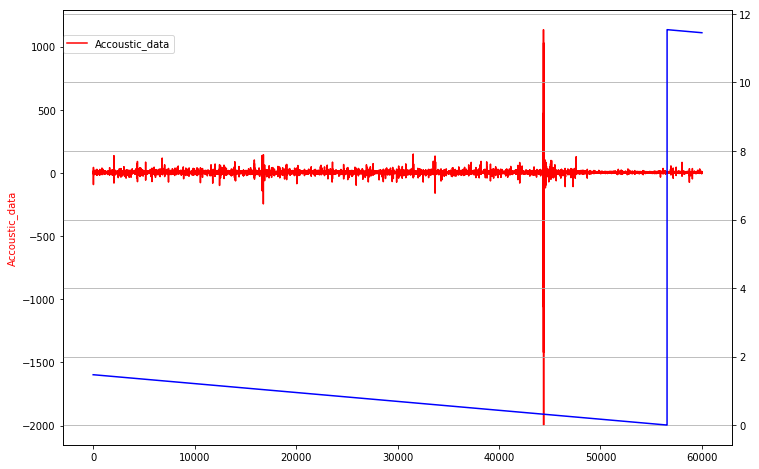

In [90]:
fig,ax1 = plt.subplots(figsize=(12, 8))
plt.plot(x,color = 'r')
ax1.set_ylabel('Accoustic_data', color = 'r')
ax1.legend(['Accoustic_data'],loc = (0,0.9))
ax2 = ax1.twinx()
plt.plot(y,color = 'b')
plt.grid(True)

In [91]:
def gen_features(X):
    strain = []
    #strain.append(X.mean())
    strain.append(X.std())
    strain.append(X.min())
    strain.append(X.max())
    #strain.append(X.kurtosis())
    #strain.append(X.skew())
    #strain.append(np.quantile(X,0.01))
    #strain.append(np.quantile(X,0.05))
    #strain.append(np.quantile(X,0.95))
    #strain.append(np.quantile(X,0.99))
    strain.append(np.abs(X).max())
    #strain.append(np.abs(X).mean())
    strain.append(np.abs(X).std())
    return pd.Series(strain)

In [92]:
train = pd.read_csv(os.path.join(PATH,'train.csv'), iterator=True, chunksize=150_000, dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})

X_train = pd.DataFrame()
y_train = pd.Series()
for df in train:
    ch = gen_features(df['acoustic_data'])
    X_train = X_train.append(ch, ignore_index=True)
    y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))

In [93]:
#machine learning
from catboost import CatBoostRegressor, Pool
#data scaling
from sklearn.preprocessing import StandardScaler
#hyperparameter optimization
from sklearn.model_selection import GridSearchCV
#support vector machine model
from sklearn.svm import NuSVR, SVR
#kernel ridge model
from sklearn.kernel_ridge import KernelRidge

In [102]:
train_pool = Pool(X_train,y_train)
m= CatBoostRegressor(iterations=10000,loss_function='MAE',boosting_type='Ordered')
m.fit(X_train,y_train,silent = True)
m.best_score_

{'learn': {'MAE': 1.9978407397801612}}

In [95]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.svm import NuSVR, SVR


scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)

#parameters = [{'gamma': [0.001, 0.005, 0.01, 0.02, 0.05, 0.1],
#               'C': [0.1, 0.2, 0.25, 0.5, 1, 1.5, 2]}]
               #'nu': [0.75, 0.8, 0.85, 0.9, 0.95, 0.97]}]

#reg1 = GridSearchCV(SVR(kernel='rbf', tol=0.01), parameters, cv=5, scoring='neg_mean_absolute_error')
#reg1.fit(X_train_scaled, y_train.values.flatten())
#y_pred1 = reg1.predict(X_train_scaled)

#print("Best CV score: {:.4f}".format(reg1.best_score_))
#print(reg1.best_params_)

In [96]:
m2 = SVR(kernel = 'rbf', tol = 0.01, C= 2, gamma=0.02)
m2.fit(X_train_scaled, y_train.values.flatten()) 

SVR(C=2, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.02,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.01, verbose=False)

In [97]:
PATH1 = os.path.join(PATH,'test')

In [98]:
X_test = pd.DataFrame()
y_test = pd.Series()
for file in os.listdir(os.path.join(PATH,'test')):
    data = pd.read_csv(os.path.join(PATH1,file), dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})
    data_fet = gen_features(data['acoustic_data'])
    X_test = X_test.append(data_fet,ignore_index = True)
    y_test = y_test.append(pd.Series(os.path.splitext(file)[0]))

In [99]:
X_test_scaled = scaler.transform(X_test)
y_pred_svr = m2.predict(X_test_scaled)

In [100]:
sub = pd.DataFrame(columns=['seg_id','time_to_failure'])
sub['seg_id'] = y_test
sub['time_to_failure'] = y_pred_svr

In [101]:
filename = 'submission1.csv'
sub.to_csv(filename,index=False)
print('Saved file: ' + filename)

Saved file: submission1.csv
